In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interp1d

# Warped

In [2]:
# Fix path by adding double backslash after E: drive letter
all_labels = torch.load(os.path.join("E:\\", "neuro2voc", "vae", "training_data", "all_labels.pt"), weights_only=True)
data_warped_speech = torch.load(os.path.join("E:\\", "neuro2voc", "vae", "training_data", "data_warped_speech.pt"), weights_only=True)
data_warped_neural = torch.load(os.path.join("E:\\", "neuro2voc", "vae", "training_data", "data_warped_neural.pt"), weights_only=True)

In [3]:
print("Speech data shape:", data_warped_speech.shape)
print("Neural data shape:", data_warped_neural.shape)

Speech data shape: torch.Size([3459, 128, 56])
Neural data shape: torch.Size([3459, 75, 27])


# Unwarped

In [136]:
all_data = True
no_warping = True
folder_name = "AOI_100hz_50ms_pre_end_bin" # stacked to 27

In [144]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "data")
label_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "labels")

# Get files and sort numerically based on filename
data_files = []
for f in os.listdir(data_dir):
    if f.endswith('.npy'):
        num = int(f.split('.')[0])  # Extract number from filename like '0000.npy'
        data_files.append((num, f))

data_files.sort()  # Sort based on the number
data_files = [f[1] for f in data_files]  # Get just the filenames

# Print lengths of first 10 files
print("Lengths of first 10 files:")
for i, file in enumerate(data_files[:10]):
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    print(f"File {i}: {data.shape[1]}")

data_list = []
label_list = []

# First pass to find minimum length
min_length = float('inf')
for file in data_files:
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    min_length = min(min_length, data.shape[1])

max_length = min_length # just for the parameters
# Second pass to load and cut data
for file in tqdm(data_files, desc="Loading data and labels"):
    # read in data
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    
    # Cut to minimum length
    data = data[:, :min_length]
    
    # read in label
    label_path = os.path.join(label_dir, file)
    label = np.load(label_path)

    data_list.append(data)
    label_list.append(label)

assert all(data.shape[0] == 75 for data in data_list), "All data should have 75 neurons"
assert all(data.shape[1] == min_length for data in data_list), "All data should have same length"

# Convert to tensors
padded_data = [torch.tensor(data, dtype=torch.float32) for data in data_list]
labels = [torch.tensor(label, dtype=torch.long).unsqueeze(0) for label in label_list]

# Stack
stacked_data = torch.stack(padded_data, dim=0)
stacked_labels = torch.cat(labels, dim=0)

print(f"Shape of stacked data: {stacked_data.shape}")
print(f"Shape of stacked labels: {stacked_labels.shape}")

Lengths of first 10 files:
File 0: 9
File 1: 9
File 2: 9
File 3: 9
File 4: 19
File 5: 11
File 6: 17
File 7: 8
File 8: 24
File 9: 20


Loading data and labels: 100%|██████████| 3459/3459 [00:00<00:00, 3713.07it/s]

Shape of stacked data: torch.Size([3459, 75, 6])
Shape of stacked labels: torch.Size([3459])


In [143]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", "dtw", "spectrogram")

data_files = []
for f in os.listdir(data_dir):
    if f.endswith('.npy'):
        num = int(f.split('_')[1])  # Extract the number after 'spec_'
        data_files.append((num, f))

data_files.sort()  # This will sort based on the number
data_files = [f[1] for f in data_files]  # Keep just the filenames

# Print lengths of first 10 files
print("Lengths of first 10 files:")
for i, file in enumerate(data_files[:10]):
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    print(f"File {i}: {data.shape[1]}")

# First pass to get length distribution
lengths = []
for file in data_files:
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    lengths.append(data.shape[1])

min_length = min(lengths)
max_length = max(lengths)
mean_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"\nLength distribution:")
print(f"Min length: {min_length}")
print(f"Max length: {max_length}")
print(f"Mean length: {mean_length:.2f}")
print(f"Std length: {std_length:.2f}")

sorted_data = []
labels = []

# Load data and labels in order
for file in tqdm(data_files, desc="Loading data and labels"):
    label = int(file.split('_')[3])  # Get label from filename
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    
    sorted_data.append(data)
    labels.append(label)

Lengths of first 10 files:
File 0: 12
File 1: 12
File 2: 11
File 3: 12
File 4: 37
File 5: 17
File 6: 30
File 7: 10
File 8: 49
File 9: 37

Length distribution:
Min length: 3
Max length: 56
Mean length: 27.63
Std length: 14.38


Loading data and labels: 100%|██████████| 3459/3459 [00:00<00:00, 7058.83it/s]


# import segments

In [2]:
# Define paths to data directories
base_path = "M:/neuro2voc/task-5/AOI_250Hz_segment_step_size_1"
neural_dir = os.path.join(base_path, "neural")
speech_dir = os.path.join(base_path, "speech")
label_dir = os.path.join(base_path, "label")

# Get files and sort numerically based on filename
data_files = []
for f in os.listdir(neural_dir):
    if f.endswith('.pt'):
        num = int(f.split('.')[0])  # Extract number from filename
        data_files.append((num, f))

data_files.sort()  # Sort based on the number
data_files = [f[1] for f in data_files]  # Get just the filenames

neural_list = []
speech_list = []
label_list = []
for file in tqdm(data_files, desc="Loading data"):
    neural_path = os.path.join(neural_dir, file)
    speech_path = os.path.join(speech_dir, file)
    label_path = os.path.join(label_dir, file)
    
    # Load with weights_only=True to avoid pickle security warning
    neural = torch.load(neural_path, weights_only=True).float()
    speech = torch.load(speech_path, weights_only=True).float()
    label = torch.load(label_path, weights_only=True).float()
    
    neural_list.append(neural)
    speech_list.append(speech)
    label_list.append(label)

# Stack all data and labels
stacked_neural = torch.stack(neural_list, dim=0)
stacked_speech = torch.stack(speech_list, dim=0)
stacked_labels = torch.stack(label_list, dim=0)

print(f"Shape of stacked neural data: {stacked_neural.shape}")
print(f"Shape of stacked speech data: {stacked_speech.shape}")
print(f"Shape of stacked labels: {stacked_labels.shape}")

Loading data: 100%|█████████▉| 132166/132577 [40:08<00:09, 44.24it/s] 

# Model

In [32]:
# class JointVAE(nn.Module):
#     def __init__(self, 
#                  neural_input_channels=75, neural_input_length=10,
#                  speech_input_channels=1, speech_height=128, speech_width=10,
#                  hidden_dim=256, latent_dim=32):
#         super(JointVAE, self).__init__()
        
#         self.neural_flatten_dim = 64 * neural_input_length  # 64 * 27 = 1728
#         self.speech_height = speech_height 
#         self.speech_width = speech_width
#         self.speech_h1 = (speech_height + 2 * 1 - 3) // 2 + 1  # After first Conv2d 38
#         self.speech_w1 = (speech_width + 2 * 1 - 3) // 2 + 1 # 
#         self.speech_h2 = (self.speech_h1 + 2 * 1 - 3) // 2 + 1  # After second Conv2d
#         self.speech_w2 = (self.speech_w1 + 2 * 1 - 3) // 2 + 1
#         self.speech_h3 = (self.speech_h2 + 2 * 1 - 3) // 2 + 1  # After third Conv2d
#         self.speech_w3 = (self.speech_w2 + 2 * 1 - 3) // 2 + 1

#         self.speech_flatten_dim = 64 * self.speech_h3 * self.speech_w3
#         self.latent_dim = latent_dim

#         # Add transformation matrices and noise parameters
#         self.neural_W = nn.Parameter(torch.randn(1,1,1,latent_dim,latent_dim))
#         self.speech_W = nn.Parameter(torch.randn(1,1,1,latent_dim,latent_dim))
#         self.neural_log_std = nn.Parameter(-torch.ones(1,1,1,1))
#         self.speech_log_std = nn.Parameter(torch.tensor(-1.0))

#         # Neural encoder
#         self.neural_encoder = nn.Sequential(
#             nn.Conv1d(neural_input_channels, 32, kernel_size=3, padding=1),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.Conv1d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(self.neural_flatten_dim, hidden_dim)
#         )
        
#         # Speech encoder
#         self.speech_encoder = nn.Sequential(
#             nn.Conv2d(speech_input_channels, 16, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.AdaptiveAvgPool2d((8, 8)),
#             nn.Flatten(),
#             nn.Linear(64 * 8 * 8, hidden_dim)
#         )

#         # Separate mu and logvar for each modality
#         self.neural_fc_mu = nn.Linear(hidden_dim, latent_dim)
#         self.neural_fc_logvar = nn.Linear(hidden_dim, latent_dim)
#         self.speech_fc_mu = nn.Linear(hidden_dim, latent_dim)
#         self.speech_fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
#         # Neural decoder
#         self.neural_decoder = nn.Sequential(
#             nn.Linear(latent_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 64 * neural_input_length),
#             nn.ReLU(),
#             nn.Unflatten(1, (64, neural_input_length)),
#             nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.ConvTranspose1d(32, neural_input_channels, kernel_size=3, padding=1)
#         )
        
#         # Speech decoder
#         self.speech_decoder = nn.Sequential(
#             nn.Linear(latent_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 64 * 8 * 8),
#             nn.ReLU(),
#             nn.Unflatten(1, (64, 8, 8)),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(1)
#         )
        
#         self.speech_final_adjust = nn.AdaptiveAvgPool2d((speech_height, speech_width))

#     def encode(self, neural_x, speech_x):
#         mus = []
#         logvars = []
        
#         # Neural encoding if data is present
#         if neural_x is not None:
#             neural_h = self.neural_encoder(neural_x)
#             neural_mu = self.neural_fc_mu(neural_h)
#             neural_logvar = self.neural_fc_logvar(neural_h)
#             # Reshape neural_mu to match the expected dimensions
#             batch_size = neural_mu.size(0)
#             neural_mu = neural_mu.view(batch_size, 1, 1, self.latent_dim)
#             # Apply transformation matrix with correct dimensions
#             neural_mu = (self.neural_W @ neural_mu.unsqueeze(-1)).squeeze(-1)
#             # Now reshape back to [batch_size, latent_dim]
#             neural_mu = neural_mu.squeeze(1).squeeze(1)
#             mus.append(neural_mu)
#             logvars.append(neural_logvar)

#         # Speech encoding if data is present
#         if speech_x is not None:
#             if len(speech_x.shape) == 3:
#                 speech_x = speech_x.unsqueeze(1)
#             speech_h = self.speech_encoder(speech_x)
#             speech_mu = self.speech_fc_mu(speech_h)
#             speech_logvar = self.speech_fc_logvar(speech_h)
#             # Reshape speech_mu to match the expected dimensions
#             batch_size = speech_mu.size(0)
#             speech_mu = speech_mu.view(batch_size, 1, 1, self.latent_dim)
#             # Apply transformation matrix with correct dimensions
#             speech_mu = (self.speech_W @ speech_mu.unsqueeze(-1)).squeeze(-1)
#             # Now reshape back to [batch_size, latent_dim]
#             speech_mu = speech_mu.squeeze(1).squeeze(1)
#             mus.append(speech_mu)
#             logvars.append(speech_logvar)

#         # Add prior N(0,1) if neither modality is present
#         if not mus:
#             device = neural_x.device if neural_x is not None else speech_x.device
#             batch_size = neural_x.shape[0] if neural_x is not None else speech_x.shape[0]
#             mus = [torch.zeros(batch_size, self.latent_dim).to(device)]
#             logvars = [torch.zeros(batch_size, self.latent_dim).to(device)]

#         # Combine using product of experts
#         return self.product_of_experts(mus, logvars)


#     def decode(self, z, decode_neural=True, decode_speech=True):
#         """Decodes the latent variable z back to the data space."""
#         # Decode neural data if required
#         neural_recon = self.neural_decoder(z) if decode_neural else None
        
#         # Decode speech data if required
#         speech_recon = self.speech_decoder(z) if decode_speech else None
#         if speech_recon is not None:
#             # Adjust speech reconstruction size if necessary
#             speech_recon = F.interpolate(
#                 speech_recon, 
#                 size=(self.speech_height, self.speech_width), 
#                 mode='bilinear', 
#                 align_corners=False
#             )
#         return neural_recon, speech_recon

#     def encode_neural_only(self, neural_data):
#         neural_h = self.neural_encoder(neural_data)
#         mu = self.fc_mu(neural_h)
#         logvar = self.fc_logvar(neural_h)
#         return mu, logvar

#     def product_of_experts(self, mus, logvars):
#         """Combine multiple Gaussian distributions using PoE."""
#         # Add prior N(0,1)
#         device = mus[0].device
#         batch_size = mus[0].shape[0]
        
#         mus.append(torch.zeros(batch_size, self.latent_dim).to(device))
#         logvars.append(torch.zeros(batch_size, self.latent_dim).to(device))
        
#         # Convert to precision (inverse variance)
#         precs = [torch.exp(-logvar) for logvar in logvars]
        
#         # PoE formula
#         prec_sum = sum(precs)
#         mu_sum = sum([mu * prec for mu, prec in zip(mus, precs)])
#         combined_mu = mu_sum / prec_sum
#         combined_var = 1 / prec_sum
#         combined_logvar = torch.log(combined_var)
        
#         return combined_mu, combined_logvar


#     def forward(self, neural_x=None, speech_x=None):
#         mu, logvar = self.encode(neural_x, speech_x)
#         z = self.reparameterize(mu, logvar)
#         neural_recon, speech_recon = self.decode(
#             z, 
#             decode_neural=neural_x is not None, 
#             decode_speech=speech_x is not None
#         )
#         return (neural_recon, speech_recon), mu, logvar

#     def reparameterize(self, mu, logvar):
#         """Performs the reparameterization trick."""
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def log_prior(self, z):
#         """Log probability of prior p(z)."""
#         return -0.5 * torch.sum(z**2, dim=-1)

#     def log_variational(self, z, mu, logvar):
#         """Log probability of q(z|x)."""
#         return -0.5 * torch.sum(
#             logvar + (z - mu)**2 / torch.exp(logvar), dim=-1
#         )

#     def log_likelihood(self, neural_recon, neural_x, speech_recon, speech_x):
#         neural_std = torch.exp(self.neural_log_std)
#         speech_std = torch.exp(self.speech_log_std)
        
#         # Compute negative log-likelihood using Gaussian assumption
#         neural_nll = 0.5 * ((neural_recon - neural_x) / neural_std).pow(2) + torch.log(neural_std)
#         neural_nll = neural_nll.sum(dim=-1)
        
#         speech_nll = 0.5 * ((speech_recon - speech_x) / speech_std).pow(2) + torch.log(speech_std)
#         speech_nll = speech_nll.sum(dim=[-1, -2, -3])  # Sum over all dimensions
        
#         return -(neural_nll + speech_nll)

#     def loss_function(self, neural_recon, neural_x, speech_recon, speech_x, mu, logvar, 
#                         beta=0.1, n_samples=1, iwae=True):
#         if iwae:
#             # Sample z
#             std = torch.exp(0.5 * logvar)
#             eps = torch.randn_like(std)
#             z = mu + eps * std
            
#             # IWAE loss components
#             log_pz = self.log_prior(z)
#             log_qz = self.log_variational(z, mu, logvar)
#             log_px = self.log_likelihood(neural_recon, neural_x, speech_recon, speech_x)
            
#             # Combine into IWAE objective
#             elbo = log_pz + log_px - log_qz - np.log(n_samples)
#             loss = -torch.logsumexp(elbo, dim=1).mean()
            
#             return loss, log_px.mean(), log_pz.mean(), -log_qz.mean()
#         else:
#             # Standard VAE loss
#             neural_loss = F.mse_loss(neural_recon, neural_x, reduction='mean')
            
#             if len(speech_x.shape) == 3 and speech_x is not None:
#                 speech_x = speech_x.unsqueeze(1)
#             speech_loss = F.mse_loss(speech_recon, speech_x, reduction='mean')
            
#             kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
            
#             total_loss = neural_loss + speech_loss + beta * kld_loss
#             return total_loss, neural_loss, speech_loss, kld_loss

In [120]:
# class SpeechDecoder(nn.Module):
#     def __init__(self, latent_dim, hidden_dim, neural_hidden_dim, speech_height, speech_width):
#         super(SpeechDecoder, self).__init__()
        
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.speech_height = speech_height  # 128
#         self.speech_width = speech_width    # 10
        
#         # initial linear layer for decoder
#         self.fc = nn.Linear(latent_dim, hidden_dim)
        
#         # transformer decoder layer with attention mechanism
#         self.transformer_decoder_layer = nn.TransformerDecoderLayer(
#             d_model=hidden_dim, nhead=4
#         )
#         self.transformer_decoder = nn.TransformerDecoder(
#             self.transformer_decoder_layer, num_layers=2
#         )
        
#         # project neural data context if dimensions don't match
#         if neural_hidden_dim != hidden_dim:
#             self.neural_proj = nn.Linear(neural_hidden_dim, hidden_dim)
#         else:
#             self.neural_proj = None
        
#         # decoder_convs
#         self.init_height = self.speech_height // 8
#         self.init_width = max(1, self.speech_width // 8)
        
#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(hidden_dim, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
#             nn.Sigmoid()
#         )

#     def forward(self, z, neural_context):
#         """
#         z: [batch_size, latent_dim]
#         neural_context: [batch_size, neural_hidden_dim]
#         """
#         # initial linear transform
#         z = self.fc(z)  # [batch_size, hidden_dim]
        
#         # prep decoder input by adding sequence length dimension
#         z = z.unsqueeze(1)  # [batch_size, seq_len=1, hidden_dim]
#         neural_context = neural_context.unsqueeze(1)  # [batch_size, seq_len=1, neural_hidden_dim]
        
#         # project neural signal if dims don't match decoder
#         if self.neural_proj is not None:
#             neural_context = self.neural_proj(neural_context)
        
#         # run through transformer decoder
#         z = self.transformer_decoder(tgt=z, memory=neural_context)  # [batch_size, seq_len=1, hidden_dim]
#         z = z.squeeze(1)  # [batch_size, hidden_dim]
        
#         # decode into image
#         z = z.view(-1, self.hidden_dim, 1, 1)  # [batch_size, hidden_dim, 1, 1]
#         z = F.interpolate(z, size=(self.init_height, self.init_width), mode='nearest')
        
#         speech_recon = self.decoder_conv(z)  # [batch_size, 1, speech_height, speech_width]
        
#         # Ensure output size matches target
#         if speech_recon.shape[-2:] != (self.speech_height, self.speech_width):
#             speech_recon = F.interpolate(
#                 speech_recon,
#                 size=(self.speech_height, self.speech_width),
#                 mode='bilinear',
#                 align_corners=False
#             )
#         return speech_recon

        
# class SupervisedVAE(nn.Module):
#     def __init__(self, 
#                  neural_input_channels=75, neural_input_length=10,
#                  speech_input_channels=1, speech_height=128, speech_width=10,
#                  hidden_dim=256, latent_dim=32):
#         super(SupervisedVAE, self).__init__()

#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim

#         # encoder for neural data
#         self.neural_encoder = nn.Sequential(
#             nn.Conv1d(neural_input_channels, 32, kernel_size=3, padding=1),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.Conv1d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Flatten()
#         )
#         with torch.no_grad():
#             sample_input = torch.zeros(1, neural_input_channels, neural_input_length)
#             sample_output = self.neural_encoder(sample_input)
#             self.neural_flatten_dim = sample_output.numel()
#         # add final linear layer
#         self.neural_encoder.add_module('fc', nn.Linear(self.neural_flatten_dim, hidden_dim))
        
#         # encoder for speech data
#         self.speech_encoder = nn.Sequential(
#             nn.Conv2d(speech_input_channels, 16, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.AdaptiveAvgPool2d((8, 8)),
#             nn.Flatten(),
#             nn.Linear(64 * 8 * 8, hidden_dim)
#         )

#         # separate mu and logvar heads for each modality
#         self.speech_fc_mu = nn.Linear(hidden_dim, latent_dim)
#         self.speech_fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
#         # decoder for speech reconstruction
#         self.speech_decoder = SpeechDecoder(
#             latent_dim=latent_dim,
#             hidden_dim=hidden_dim,
#             neural_hidden_dim=hidden_dim,
#             speech_height=speech_height,
#             speech_width=speech_width
#         )

#     def encode(self, neural_x, speech_x):
#         # encode neural signal if present
#         neural_h = self.neural_encoder(neural_x) if neural_x is not None else None
        
#         # encode speech signal if present
#         speech_h = self.speech_encoder(speech_x) if speech_x is not None else None
        
#         # get mu and logvar from speech encoding
#         if speech_h is not None:
#             mu = self.speech_fc_mu(speech_h)
#             logvar = self.speech_fc_logvar(speech_h)
#         else:
#             # use zero mean and unit variance if no speech signal
#             device = neural_x.device if neural_x is not None else speech_x.device
#             batch_size = neural_x.shape[0] if neural_x is not None else speech_x.shape[0]
#             mu = torch.zeros(batch_size, self.latent_dim).to(device)
#             logvar = torch.zeros(batch_size, self.latent_dim).to(device)
        
#         return neural_h, mu, logvar

#     def decode(self, z, neural_context=None):
#         """turns latent z back into speech data"""
#         speech_recon = self.speech_decoder(z, neural_context)
#         return speech_recon

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, neural_x=None, speech_x=None):
#         neural_h, mu, logvar = self.encode(neural_x, speech_x)
#         z = self.reparameterize(mu, logvar)
#         speech_recon = self.decode(z, neural_context=neural_h)
#         return speech_recon, mu, logvar
#     def loss_function(self, speech_recon, speech_x, mu, logvar, beta=1.0):  # beta parameter for KLD weight
#         # calculate speech reconstruction loss
#         if len(speech_x.shape) == 3:
#             speech_x = speech_x.unsqueeze(1)
        
#         # Combine L1 and MSE loss
#         mse_loss = F.mse_loss(speech_recon, speech_x, reduction='mean')
#         l1_loss = F.l1_loss(speech_recon, speech_x, reduction='mean')
#         speech_loss = mse_loss + 0.5 * l1_loss
        
#         # Calculate KLD loss with minimum threshold
#         kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
#         kld_loss = torch.max(kld_loss.mean(), torch.tensor(0.1).to(kld_loss.device))
        
#         # Combine losses with beta weighting
#         total_loss = speech_loss + beta * kld_loss
        
#         return total_loss, speech_loss.item(), kld_loss.item()

In [ ]:
class SpeechVAE(nn.Module):
    def __init__(self, 
                 speech_input_channels=1, speech_height=128, speech_width=10,
                 hidden_dim=256, latent_dim=32):
        super(SpeechVAE, self).__init__()
        
        self.latent_dim = latent_dim

        self.speech_encoder_conv = nn.Sequential(
            nn.BatchNorm2d(speech_input_channels),
            nn.Conv2d(speech_input_channels, 16, 3, 1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, 2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        with torch.no_grad():
            sample_input = torch.zeros(1, speech_input_channels, speech_height, speech_width)
            conv_output = self.speech_encoder_conv(sample_input)
            flatten_size = conv_output.view(-1).size(0)

        self.speech_encoder_fc = nn.Sequential(
            nn.Linear(flatten_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  
        )


        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, flatten_size),
            nn.ReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, speech_input_channels, 3, 2, padding=1, output_padding=1),
        )

        self.final_adjust = nn.AdaptiveAvgPool2d((speech_height, speech_width))

    def encode(self, speech_x):
        h = self.speech_encoder_conv(speech_x)
        h = h.view(h.size(0), -1)
        h = self.speech_encoder_fc(h)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 64, -1, -1)
        h = self.decoder_conv(h)
        h = self.final_adjust(h)
        return h

    def forward(self, speech_x):
            mu, logvar = self.encode(speech_x)
            z = self.reparameterize(mu, logvar)
            recon_x = self.decode(z)
            return recon_x, mu, logvar

    def loss_function(self, recon_x, speech_x, mu, logvar, beta=0.1):
        recon_loss = F.mse_loss(recon_x, speech_x, reduction='mean')
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = recon_loss + beta * kld_loss
        return total_loss, recon_loss, kld_loss

In [ ]:
class CombinedVAE(nn.Module):
    def __init__(self, 
                 neural_input_channels=75, neural_input_length=10,
                 speech_input_channels=1, speech_height=128, speech_width=10,
                 hidden_dim=256, latent_dim=32):
        super(CombinedVAE, self).__init__()

        self.latent_dim = latent_dim

        self.neural_encoder = nn.Sequential(
            nn.Conv1d(neural_input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * neural_input_length, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.speech_encoder_conv = nn.Sequential(
            nn.BatchNorm2d(speech_input_channels),
            nn.Conv2d(speech_input_channels, 16, 3, 1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, 2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        with torch.no_grad():
            sample_input = torch.zeros(1, speech_input_channels, speech_height, speech_width)
            conv_output = self.speech_encoder_conv(sample_input)
            flatten_size = conv_output.view(-1).size(0)

        self.speech_encoder_fc = nn.Sequential(
            nn.Linear(flatten_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  
        )


        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, flatten_size),
            nn.ReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, speech_input_channels, 3, 2, padding=1, output_padding=1),
        )

        self.final_adjust = nn.AdaptiveAvgPool2d((speech_height, speech_width))

    def encode(self, neural_x, speech_x):
        neural_z = self.neural_encoder(neural_x) if neural_x is not None else None

        if speech_x is not None:
            h = self.speech_encoder_conv(speech_x)
            h = h.view(h.size(0), -1)
            h = self.speech_encoder_fc(h)
            mu, logvar = torch.chunk(h, 2, dim=1)
        else:
            device = neural_x.device if neural_x is not None else 'cpu'
            batch_size = neural_x.size(0) if neural_x is not None else speech_x.size(0)
            mu = torch.zeros(batch_size, self.latent_dim).to(device)
            logvar = torch.zeros(batch_size, self.latent_dim).to(device)

        return neural_z, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 64, -1, -1)
        h = self.decoder_conv(h)
        h = self.final_adjust(h)
        return h

    def forward(self, neural_x=None, speech_x=None):
        neural_z, mu, logvar = self.encode(neural_x, speech_x)
        
        if speech_x is not None:
            speech_z = mu
        else:
            speech_z = None
            
        if neural_z is not None:
            z = neural_z
        else:
            z = self.reparameterize(mu, logvar) 
            
        recon_x = self.decode(z)
        
        return recon_x, neural_z, speech_z, mu, logvar

    def loss_function(self, recon_x, speech_x, mu, logvar, alpha=1.0, beta=0.1, gamma=1.0):
        recon_loss = F.mse_loss(recon_x, speech_x, reduction='mean')
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        if neural_z is not None and speech_z is not None:
            contrastive_loss = self.contrastive_loss(neural_z, speech_z)
        else:
            contrastive_loss = torch.tensor(0.0).to(speech_x.device)

        total_loss = alpha * recon_loss + beta * kld_loss + gamma * contrastive_loss
        return total_loss, recon_loss, kld_loss, contrastive_loss

    def contrastive_loss(self, neural_z, speech_z, temperature=0.07):
        neural_z_normalized = F.normalize(neural_z, dim=1)
        speech_z_normalized = F.normalize(speech_z, dim=1)
        
        similarity_matrix = torch.matmul(neural_z_normalized, speech_z_normalized.T) / temperature
        
        batch_size = neural_z.size(0)
        labels = torch.arange(batch_size).long().to(neural_z.device)
        
        loss_i = F.cross_entropy(similarity_matrix, labels)
        loss_t = F.cross_entropy(similarity_matrix.T, labels)
        
        loss = (loss_i + loss_t) / 2
        return loss

# Dataset (Old, warped)

In [87]:
# class JointDataset(torch.utils.data.Dataset):
#     def __init__(self, neural_data, speech_data):
#         self.neural_data = neural_data
#         self.speech_data = speech_data
        
#     def __len__(self):
#         return len(self.neural_data)
    
#     def __getitem__(self, idx):
#         return self.neural_data[idx], self.speech_data[idx]

# def create_dataloaders(neural_data, speech_data, batch_size=128, train_split=0.8, shuffle=True):
#     neural_tensor = torch.FloatTensor(neural_data)
#     speech_tensor = torch.FloatTensor(speech_data)
    
#     split_idx = int(len(neural_tensor) * train_split)
    
#     train_dataset = JointDataset(
#         neural_tensor[:split_idx], 
#         speech_tensor[:split_idx]
#     )
#     val_dataset = JointDataset(
#         neural_tensor[split_idx:], 
#         speech_tensor[split_idx:]
#     )
    
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=batch_size, 
#         shuffle=shuffle
#     )
#     val_loader = DataLoader(
#         val_dataset, 
#         batch_size=batch_size, 
#         shuffle=False
#     )
    
#     return train_loader, val_loader

In [88]:
# print("Neural data shape:", data_warped_neural.shape)  # [3459, 75, 27]
# print("Speech data shape:", data_warped_speech.shape)  # [3459, 128, 56]

# dataset = JointDataset(data_warped_neural, data_warped_speech)
# train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [89]:
# print("Neural data shape:", data_warped_neural.shape)  # [3459, 75, 27]
# print("Speech data shape:", data_warped_speech.shape)  # [3459, 128, 56]

# dataset = JointDataset(data_warped_neural, data_warped_speech)
# train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Dataset

In [121]:
from torch.utils.data import Dataset, DataLoader, random_split

class SupervisedDataset(Dataset):
    def __init__(self, neural_data, speech_data):
        """
        neural_data: tensor of shape [batch_size, neural_input_channels, neural_seq_len]
        speech_data: tensor of shape [batch_size, speech_input_channels, speech_height, speech_width]
        """
        self.neural_data = neural_data
        self.speech_data = speech_data
        
        # Reshape speech data to [batch_size, 1, height, width] for 2D convolutions
        if len(speech_data.shape) == 3:
            self.speech_data = speech_data.unsqueeze(1)
            
    def __len__(self):
        return len(self.neural_data)
    
    def __getitem__(self, idx):
        return self.neural_data[idx], self.speech_data[idx]

# Create datasets
dataset = SupervisedDataset(stacked_neural, stacked_speech)


# Create data loaders
batch_size = 2048
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)


In [122]:
print("Neural data shape:", dataset.neural_data.shape)
print("Speech data shape:", dataset.speech_data.shape)

Neural data shape: torch.Size([132577, 75, 10])
Speech data shape: torch.Size([132577, 1, 128, 10])


# Training

In [115]:
# def train_joint_vae(model, train_loader, val_loader, num_epochs=100):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode='min', factor=0.5, patience=5
#     )
    
#     # Keep track of losses over time
#     history = {
#         'train_loss': [], 'val_loss': [],
#         'neural_loss': [], 'speech_loss': [],
#         'kld_loss': [], 'contrastive_loss': []
#     }
    
#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         train_losses = []
#         metrics_sum = {k: 0.0 for k in history.keys() if k != 'train_loss' and k != 'val_loss'}
        
#         for neural_batch, speech_batch in tqdm(train_loader):
#             neural_batch = neural_batch.to(device)
#             speech_batch = speech_batch.to(device)
            
#             optimizer.zero_grad()
            
#             # Run data through model
#             (neural_recon, speech_recon), mu, logvar = model(neural_batch, speech_batch)
            
#             # Calculate all the losses
#             loss, metrics = model.loss_function(
#                 neural_recon, neural_batch,
#                 speech_recon, speech_batch,
#                 mu, logvar
#             )
            
#             # Backprop!
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
            
#             train_losses.append(loss.item())
#             for k in metrics_sum.keys():
#                 metrics_sum[k] += metrics[k]
            
#         # Validation phase - no gradients needed
#         model.eval()
#         val_losses = []
#         with torch.no_grad():
#             for neural_batch, speech_batch in val_loader:
#                 neural_batch = neural_batch.to(device)
#                 speech_batch = speech_batch.to(device)
                
#                 (neural_recon, speech_recon), mu, logvar = model(neural_batch, speech_batch)
#                 loss, _ = model.loss_function(
#                     neural_recon, neural_batch,
#                     speech_recon, speech_batch,
#                     mu, logvar
#                 )
#                 val_losses.append(loss.item())
        
#         # Update learning rate if validation loss plateaus
#         scheduler.step(np.mean(val_losses))
        
#         # Save everything to history
#         history['train_loss'].append(np.mean(train_losses))
#         history['val_loss'].append(np.mean(val_losses))
#         for k in metrics_sum.keys():
#             history[k].append(metrics_sum[k] / len(train_loader))
            
#         # Print out how we're doing
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         print(f"Train Loss: {history['train_loss'][-1]:.4f}")
#         print(f"Val Loss: {history['val_loss'][-1]:.4f}")
#         for k in metrics_sum.keys():
#             print(f"{k}: {history[k][-1]:.4f}")

In [123]:
def train_supervised_vae(model, train_loader, val_loader, num_epochs=100, learning_rate=3e-4, device=device):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0.01
    )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,  # heat up ratio
        div_factor=25,  # max_lr/25
        final_div_factor=100,  # max_lr/1000
    )
    
    history = {
        'train_loss': [], 'val_loss': [],
        'speech_loss': [], 'kld_loss': []
    }
    
    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        speech_losses = []
        kld_losses = []
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for neural_batch, speech_batch in progress_bar:
            neural_batch = neural_batch.to(device)
            speech_batch = speech_batch.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            speech_recon, mu, logvar = model(neural_batch, speech_batch)
            
            # Calculate loss
            loss, speech_loss, kld_loss = model.loss_function(
                speech_recon, speech_batch, mu, logvar
            )
            
            # Backprop!
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
            speech_losses.append(speech_loss)
            kld_losses.append(kld_loss)
            
            progress_bar.set_postfix({
                'train_loss': f'{np.mean(train_losses):.4f}',
                'speech_loss': f'{np.mean(speech_losses):.4f}',
                'kld_loss': f'{np.mean(kld_losses):.4f}'
            })
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for neural_batch, speech_batch in val_loader:
                neural_batch = neural_batch.to(device)
                speech_batch = speech_batch.to(device)
                
                speech_recon, mu, logvar = model(neural_batch, speech_batch)
                loss, _, _ = model.loss_function(
                    speech_recon, speech_batch, mu, logvar
                )
                val_losses.append(loss.item())
        
        # Calculate average losses and save to history
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['speech_loss'].append(np.mean(speech_losses))
        history['kld_loss'].append(np.mean(kld_losses))
        
        # Save checkpoint every 100 epochs
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f'model_checkpoint_epoch_{epoch+1}.pt')
    
    print("Training completed!")
    return history

### Model and optimizer

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SupervisedVAE(
    neural_input_channels=75, 
    neural_input_length=10,
    speech_input_channels=1, 
    speech_height=128, 
    speech_width=10,
    hidden_dim=256, 
    latent_dim=32
).to(device)

# model = JointVAE(
#     neural_input_channels=75, 
#     neural_input_length=27, 
#     speech_input_channels=1, 
#     speech_height=128, 
#     speech_width=56, 
#     hidden_dim=256, 
#     latent_dim=32
# )

# train_loader, val_loader = create_dataloaders(
#     data_warped_neural.numpy(), 
#     data_warped_speech.numpy(),
#     batch_size=128
# )



In [126]:
# Train the model
train_supervised_vae(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=1000,
    learning_rate=1e-4,
    device=device
)

Starting training...


Epoch 18/1000:  92%|█████████▏| 48/52 [00:04<00:00, 11.36it/s, train_loss=4144.0251, speech_loss=4143.9250, kld_loss=0.1000]


KeyboardInterrupt: 

In [14]:
# torch.save(model.state_dict(), 'training_data/model_joint_vae.pt')


# Load model

In [127]:
model = JointVAE(
    neural_input_channels=75, 
    neural_input_length=27, 
    speech_input_channels=1, 
    speech_height=128, 
    speech_width=56, 
    hidden_dim=256, 
    latent_dim=32
).to(device)

model.load_state_dict(torch.load('training_data/model_joint_vae.pt'))

model.eval()

C:\Users\askrb\AppData\Local\Temp\ipykernel_39760\1606901947.py:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



JointVAE(
  (neural_encoder): Sequential(
    (0): Conv1d(75, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1728, out_features=256, bias=True)
    (8): ReLU()
  )
  (speech_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): AdaptiveAv

# Visualize

In [128]:
def get_reconstruction(model, neural_data, speech_data, device='cuda'):
    # Ensure model is in eval mode
    model.eval()
    
    # Move data to device and handle batch dimension
    if len(neural_data.shape) == 2:  # If single sample
        neural_data = neural_data.unsqueeze(0)
    if len(speech_data.shape) == 2:  # If single sample
        speech_data = speech_data.unsqueeze(0)
    if len(speech_data.shape) == 3:  # If channel dimension is missing
        speech_data = speech_data.unsqueeze(1)
        
    original_neural = neural_data.to(device)
    original_speech = speech_data.to(device)
    
    # Get reconstructions
    with torch.no_grad():
        (reconstructed_neural, reconstructed_speech), _, _ = model(original_neural, original_speech)
    
    # Move everything to CPU for easier handling
    result = {
        'original_neural': original_neural.cpu(),
        'original_speech': original_speech.cpu(),
        'reconstructed_neural': reconstructed_neural.cpu(),
        'reconstructed_speech': reconstructed_speech.cpu()
    }
    
    # Print shapes for verification
    print("Shapes:")
    for key, value in result.items():
        print(f"{key}: {value.shape}")
        
    return result

In [129]:
# Convert data to float32 before creating dataloaders
data_warped_neural = data_warped_neural.float()
data_warped_speech = data_warped_speech.float()

train_loader, _ = create_dataloaders(data_warped_neural, data_warped_speech, batch_size=1)
sample_neural, sample_speech = next(iter(train_loader))

reconstructions = get_reconstruction(model, sample_neural, sample_speech)

# Squeeze out batch dimensions since batch_size=1
reconstructions = {
    'original_neural': reconstructions['original_neural'].squeeze(),
    'original_speech': reconstructions['original_speech'].squeeze(), 
    'reconstructed_neural': reconstructions['reconstructed_neural'].squeeze(),
    'reconstructed_speech': reconstructions['reconstructed_speech'].squeeze()
}

# Print shapes after squeezing
print("\nShapes after squeezing:")
for key, value in reconstructions.items():
    print(f"{key}: {value.shape}")


Shapes:
original_neural: torch.Size([1, 75, 27])
original_speech: torch.Size([1, 1, 128, 56])
reconstructed_neural: torch.Size([1, 75, 27])
reconstructed_speech: torch.Size([1, 1, 128, 56])

Shapes after squeezing:
original_neural: torch.Size([75, 27])
original_speech: torch.Size([128, 56])
reconstructed_neural: torch.Size([75, 27])
reconstructed_speech: torch.Size([128, 56])


In [130]:
def plot_reconstructions(reconstructions, filename):
    """
    Plot original and reconstructed data side by side
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot neural data as 2D heatmaps
    im1 = axes[0,0].imshow(reconstructions['original_neural'].numpy(), aspect='auto', cmap='viridis')
    axes[0,0].set_title('Original Data')
    axes[0,0].set_xlabel('Time (ms)')
    axes[0,0].set_ylabel('Neuron')
    # Set x-axis ticks every 10ms
    axes[0,0].set_xticks(np.arange(0, reconstructions['original_neural'].shape[1], 5))
    axes[0,0].set_xticklabels(np.arange(0, reconstructions['original_neural'].shape[1]*10, 50))
    plt.colorbar(im1, ax=axes[0,0], label='Amplitude')
    
    im2 = axes[0,1].imshow(reconstructions['reconstructed_neural'].numpy(), aspect='auto', cmap='viridis')
    axes[0,1].set_title('Reconstructed Data')
    axes[0,1].set_xlabel('Time (ms)')
    axes[0,1].set_ylabel('Neuron')
    # Set x-axis ticks every 10ms
    axes[0,1].set_xticks(np.arange(0, reconstructions['reconstructed_neural'].shape[1], 5))
    axes[0,1].set_xticklabels(np.arange(0, reconstructions['reconstructed_neural'].shape[1]*10, 50))
    plt.colorbar(im2, ax=axes[0,1], label='Amplitude')
    
    # Plot speech spectrograms
    # Convert to dB scale
    orig_speech_db = 20 * torch.log10(reconstructions['original_speech'] + 1e-10)
    recon_speech_db = 20 * torch.log10(reconstructions['reconstructed_speech'] + 1e-10)
    
    # Get global min/max for consistent scaling
    vmin = min(orig_speech_db.min(), recon_speech_db.min())
    vmax = max(orig_speech_db.max(), recon_speech_db.max())
    
    im3 = axes[1,0].imshow(orig_speech_db.numpy(), aspect='auto', cmap='viridis',
                          origin='lower', extent=[0, orig_speech_db.shape[1], 0, 8000],
                          vmin=vmin, vmax=vmax)
    axes[1,0].set_title('Original Data')
    axes[1,0].set_xlabel('Time (ms)')
    axes[1,0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im3, ax=axes[1,0], label='Amplitude (dB)')
    
    im4 = axes[1,1].imshow(recon_speech_db.numpy(), aspect='auto', cmap='viridis',
                          origin='lower', extent=[0, recon_speech_db.shape[1], 0, 8000],
                          vmin=vmin, vmax=vmax)
    axes[1,1].set_title('Reconstructed Data')
    axes[1,1].set_xlabel('Time (ms)')
    axes[1,1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im4, ax=axes[1,1], label='Amplitude (dB)')
    
    plt.tight_layout()
    plt.savefig('reconstructions'+filename+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()

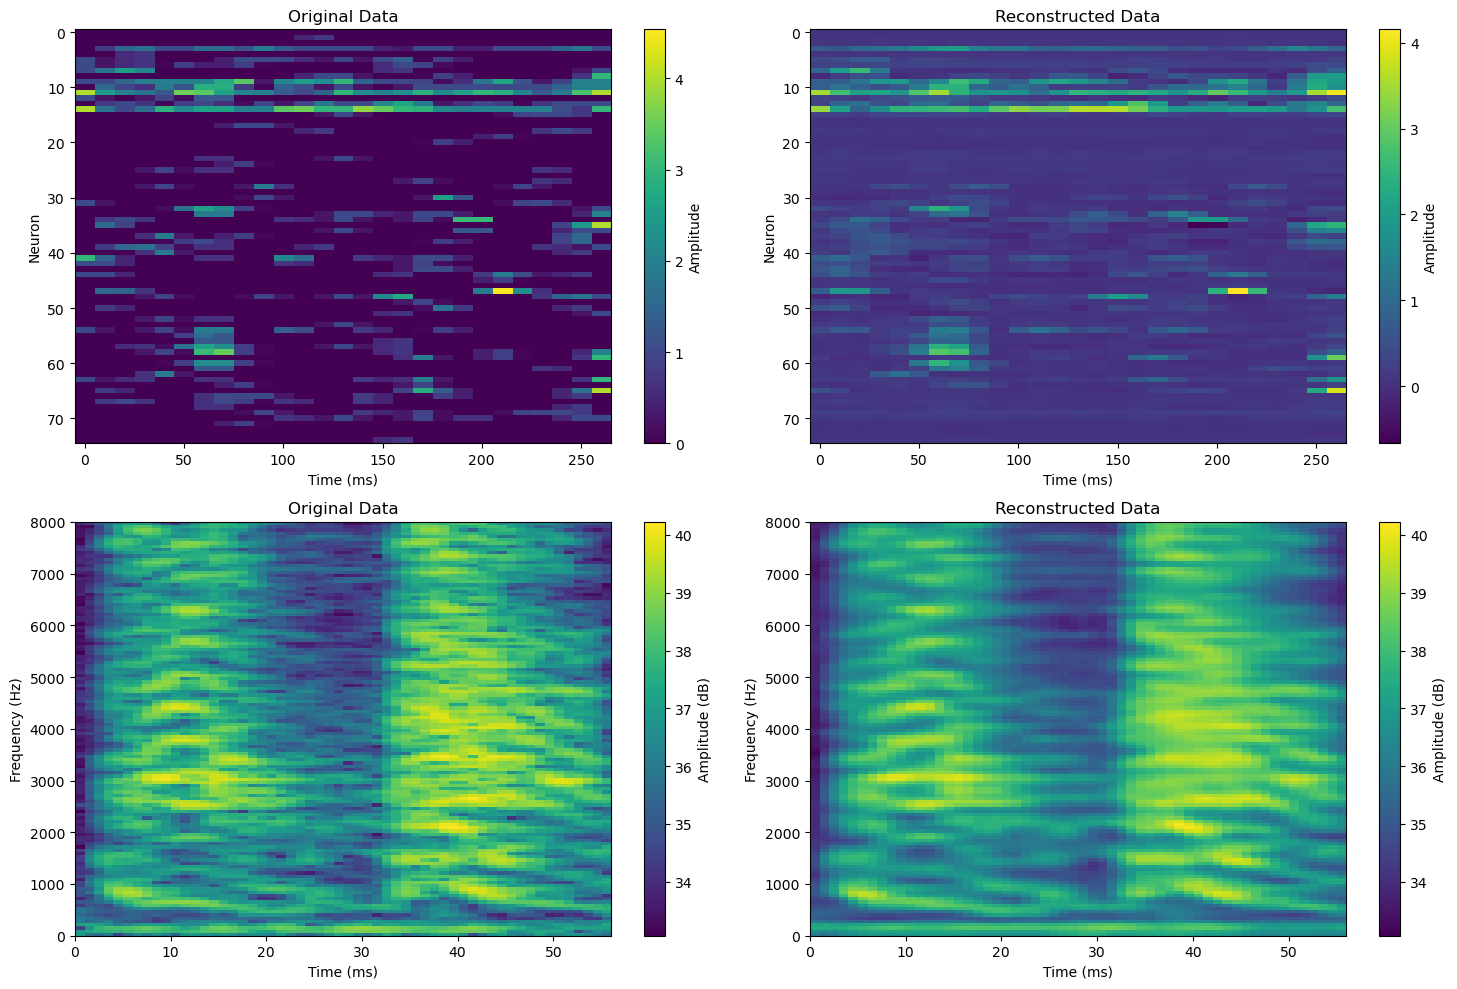

In [131]:
# Visualize the reconstructions 
plot_reconstructions(reconstructions, '7')

In [134]:
def neural_to_speech(model, neural_data, original_speech=None, device='cuda'):
    """
    Convert neural data to speech data using the trained VAE.
    
    Args:
        model: trained JointVAE model
        neural_data: neural input data [batch_size, 75, 27]
        original_speech: (optional) original speech data for comparison
        device: computation device ('cuda' or 'cpu')
    
    Returns:
        dict containing original neural, predicted speech, and (if provided) original speech data
    """
    # Ensure model is in eval mode
    model.eval()
    
    # Handle batch dimension for neural data
    if len(neural_data.shape) == 2:  # If single sample
        neural_data = neural_data.unsqueeze(0)
    
    # Move data to device
    neural_data = neural_data.to(device)
    
    # Get latent representation and reconstruction
    with torch.no_grad():
        mu, _ = model.encode(neural_data, None)  # Pass None for speech_x
        neural_recon, predicted_speech = model.decode(mu)
    
    # Prepare result dictionary
    result = {
        'original_neural': neural_data.squeeze().cpu(),
        'predicted_speech': predicted_speech.squeeze().cpu(),
    }
    
    # If original speech is provided, add it to results
    if original_speech is not None:
        result['original_speech'] = original_speech.squeeze().to('cpu')
    
    # Print shapes for verification
    print("Shapes:")
    for key, value in result.items():
        print(f"{key}: {value.shape}")
        
    return result


In [135]:
train_loader, _ = create_dataloaders(data_warped_neural, data_warped_speech, batch_size=1)
sample_neural, sample_speech = next(iter(train_loader))

# Get speech prediction from neural data
results = neural_to_speech(model, sample_neural, original_speech=sample_speech)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x256 and 512x32)

In [68]:
def plot_neural_to_speech(results):
    """
    Plot neural input and resulting speech output
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot neural data
    neural_data = results['original_neural']
    im1 = axes[0].imshow(neural_data.numpy(), aspect='auto', cmap='viridis')
    axes[0].set_title('Neural Input')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('Neuron')
    # Set x-axis ticks every 10ms
    axes[0].set_xticks(np.arange(0, neural_data.shape[1], 5))
    axes[0].set_xticklabels(np.arange(0, neural_data.shape[1]*10, 50))
    plt.colorbar(im1, ax=axes[0], label='Amplitude')

    # Plot predicted speech spectrogram
    # Convert to dB scale
    pred_speech_db = 20 * torch.log10(results['predicted_speech'] + 1e-10)
    im2 = axes[1].imshow(pred_speech_db.numpy(), aspect='auto', cmap='viridis',
                        origin='lower', extent=[0, pred_speech_db.shape[1], 0, 8000],
                        vmin=pred_speech_db.numpy().min(), vmax=pred_speech_db.numpy().max()-2)
    axes[1].set_title('Predicted Speech')
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im2, ax=axes[1], label='Amplitude (dB)')

    # Plot original speech spectrogram
    # Convert to dB scale
    orig_speech_db = 20 * torch.log10(results['original_speech'] + 1e-10)
    im3 = axes[2].imshow(orig_speech_db.numpy(), aspect='auto', cmap='viridis',
                        origin='lower', extent=[0, orig_speech_db.shape[1], 0, 8000])
    axes[2].set_title('Original Speech')
    axes[2].set_xlabel('Time (ms)')
    axes[2].set_ylabel('Frequency (Hz)')
    plt.colorbar(im3, ax=axes[2], label='Amplitude (dB)')

    # Print shapes
    print("Original Neural:", results['original_neural'].shape)
    print("Predicted Speech:", results['predicted_speech'].shape) 
    print("Original Speech:", results['original_speech'].shape)

    plt.tight_layout()
    plt.show()

Original Neural: torch.Size([75, 27])
Predicted Speech: torch.Size([128, 56])
Original Speech: torch.Size([128, 56])


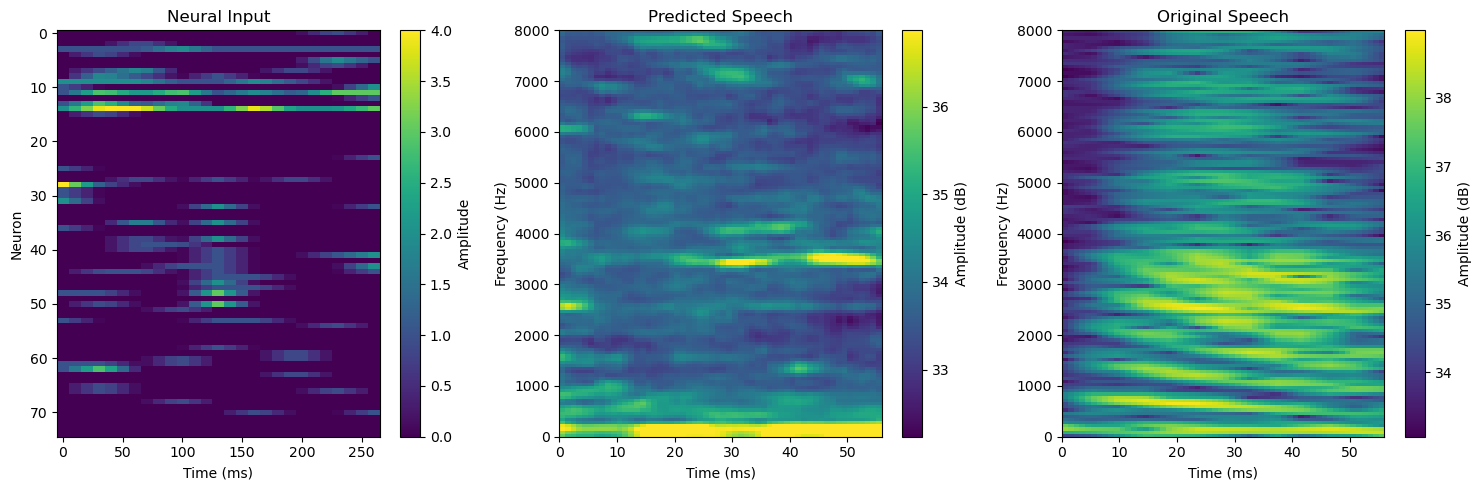

In [69]:

# Visualize the results
plot_neural_to_speech(results)

# t-SNE

In [74]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px  # For interactive 3D visualization

def get_latent_embeddings(model, dataloader, device='cuda'):
    """
    Get latent embeddings (mu) for all data points in the dataloader
    """
    model.eval()
    all_mu = []
    
    with torch.no_grad():
        for batch_neural, batch_speech in dataloader:
            batch_neural = batch_neural.to(device)
            batch_speech = batch_speech.to(device)
            
            # Get mu from the encoder
            mu, _ = model.encode(batch_neural, batch_speech)
            all_mu.append(mu.cpu().numpy())
    
    # Concatenate all batches
    latent_embeddings = np.concatenate(all_mu, axis=0)
    return latent_embeddings

def visualize_latent_space_3d(latent_embeddings, labels=None, perplexity=30):
    """
    Create 3D t-SNE visualization of latent space
    """
    # Reduce dimensionality to 3D using t-SNE
    tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    embeddings_3d = tsne.fit_transform(latent_embeddings)
    
    # Create DataFrame for plotting
    df = pd.DataFrame(embeddings_3d, columns=['TSNE1', 'TSNE2', 'TSNE3'])
    
    if labels is not None:
        df['Label'] = labels
        
        # Create 3D scatter plot with labels
        fig = px.scatter_3d(df, x='TSNE1', y='TSNE2', z='TSNE3',
                           color='Label',
                           title='3D t-SNE visualization of latent space')
    else:
        # Create 3D scatter plot without labels
        fig = px.scatter_3d(df, x='TSNE1', y='TSNE2', z='TSNE3',
                           title='3D t-SNE visualization of latent space')
    
    fig.update_traces(marker=dict(size=5))
    fig.show()

In [77]:
# Get the embeddings
train_loader, _ = create_dataloaders(data_warped_neural, data_warped_speech, batch_size=128, train_split=1, shuffle=False)
latent_embeddings = get_latent_embeddings(model, train_loader, device)

# Ensure labels match embeddings length
if len(all_labels) != latent_embeddings.shape[0]:
    # Truncate labels to match embeddings length
    all_labels = all_labels[:latent_embeddings.shape[0]]

# Visualize with labels
visualize_latent_space_3d(latent_embeddings, labels=all_labels)

In [76]:
len(all_labels)

3459

# GPT code:

In [79]:
from sklearn.manifold import TSNE

def visualize_joint_space(model, neural_data, speech_data, labels=None):
    neural_latent = model.encode(neural_data, None)[0].detach().cpu()
    speech_latent = model.encode(None, speech_data)[0].detach().cpu()
    
    tsne = TSNE(n_components=2)
    neural_2d = tsne.fit_transform(neural_latent)
    speech_2d = tsne.fit_transform(speech_latent)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.scatter(neural_2d[:, 0], neural_2d[:, 1], c=labels)
    plt.title('Neural Latent Space')
    
    plt.subplot(122)
    plt.scatter(speech_2d[:, 0], speech_2d[:, 1], c=labels)
    plt.title('Speech Latent Space')
    plt.show()

In [81]:
def transfer_features(model, source_neural, target_neural):
    """使用联合空间进行特征迁移"""
    # 编码源数据
    source_latent = model.encode(source_neural, None)[0]
    
    # 编码目标数据
    target_latent = model.encode(target_neural, None)[0]
    
    # 计算特征映射
    transfer_matrix = torch.mm(
        torch.pinverse(source_latent), 
        target_latent
    )
    
    return transfer_matrix

In [82]:
def conditional_generation(model, neural_condition, num_samples=5):
    """基于神经条件生成语音变体"""
    # 获取条件的潜在表示
    neural_latent = model.encode(neural_condition, None)[0]
    
    # 添加随机噪声生成多个变体
    noise = torch.randn_like(neural_latent).mul(0.1)
    variants = neural_latent + noise
    
    # 解码生成语音
    speech_variants = model.decode(variants)[1]
    
    return speech_variants

In [83]:
def align_modalities(model, neural_sequence, speech_sequence):
    """对齐神经和语音序列"""
    # 获取两个序列的潜在表示
    neural_latents = model.encode(neural_sequence, None)[0]
    speech_latents = model.encode(None, speech_sequence)[0]
    
    # 计算动态时间规整(DTW)
    from scipy.spatial.distance import cdist
    from fastdtw import fastdtw
    
    distances = cdist(
        neural_latents.cpu().numpy(), 
        speech_latents.cpu().numpy()
    )
    path, _ = fastdtw(neural_latents.cpu(), speech_latents.cpu())
    
    return path

In [84]:
def detect_anomalies(model, neural_data, speech_data, threshold=2.0):
    """检测异常的神经-语音配对"""
    # 获取潜在表示
    neural_latent = model.encode(neural_data, None)[0]
    speech_latent = model.encode(None, speech_data)[0]
    
    # 计算重建误差
    neural_recon = model.decode(neural_latent)[0]
    speech_recon = model.decode(speech_latent)[1]
    
    neural_error = F.mse_loss(neural_recon, neural_data, reduction='none')
    speech_error = F.mse_loss(speech_recon, speech_data, reduction='none')
    
    # 标记异常
    total_error = neural_error + speech_error
    anomalies = total_error > threshold * total_error.mean()
    
    return anomalies